# Neuro-Fuzzy Classifier and MNIST
In this notebook I will constructing the neuro-fuzzy classifier in Keras and testing its performance on the original MNIST data.

## Loading the Training Data
The MNIST data is downloaded from http://yann.lecun.com/exdb/mnist/ and kept in the same directory as this notebook. The images and labels will be loaded into NumPy arrays for further processing.

In [1]:
import gzip
import numpy as np

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)
    
train_images = load_data("data/mnist/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/mnist/train-labels-idx1-ubyte.gz", [60000])

test_images = load_data("data/mnist/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/mnist/t10k-labels-idx1-ubyte.gz", [10000])

Convert the image data from unsigned bytes ranging from 0-255 to 32-bit floating-point numbers ranging from 0-1.

In [2]:
train_images = train_images.astype(np.float) / 255
test_images = test_images.astype(np.float) / 255

Plot an image from the training images and labels to ensure that the data was loaded correctly.

The digit 5:


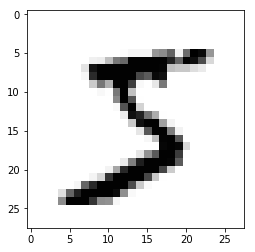

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(train_images[0,:,:], cmap="Greys", interpolation="none")
print("The digit {}:".format(train_labels[0]))

## Fuzzy C-Means Clustering
The membership functions for the neuro-fuzzy classifier are initialized using fuzzy c-means clustering. Fuzzy clustering can be more difficult to apply in high dimensional spaces, and can often fail to find an appropriate solution. The dimension reduction technique UMAP will be used to visualize the MNIST data and the fuzzy centers in a 2D feature space. 

As shown below, the data forms a distinct cluster for each digit.

The UMAP computations were done using this package: https://github.com/lmcinnes/umap

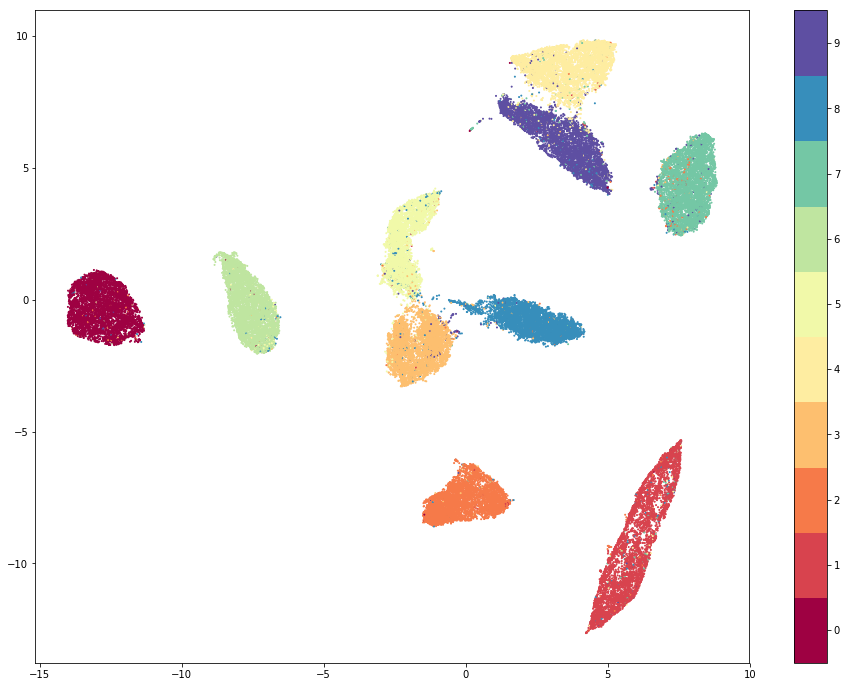

In [4]:
from umap import UMAP

# reshape the training images into vectors
data = train_images.reshape(60000, 28 * 28)

# create the mapping and apply it
reducer = UMAP(n_neighbors=10, min_dist=0.001, random_state=42).fit(data)
embedded = reducer.transform(data)

# plot the data
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:,0], embedded[:,1], s=1, c=train_labels, cmap='Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

Next, we attempt fuzzy clustering using a random initialization.

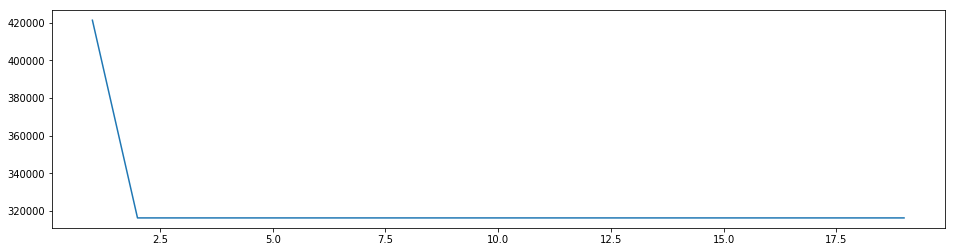

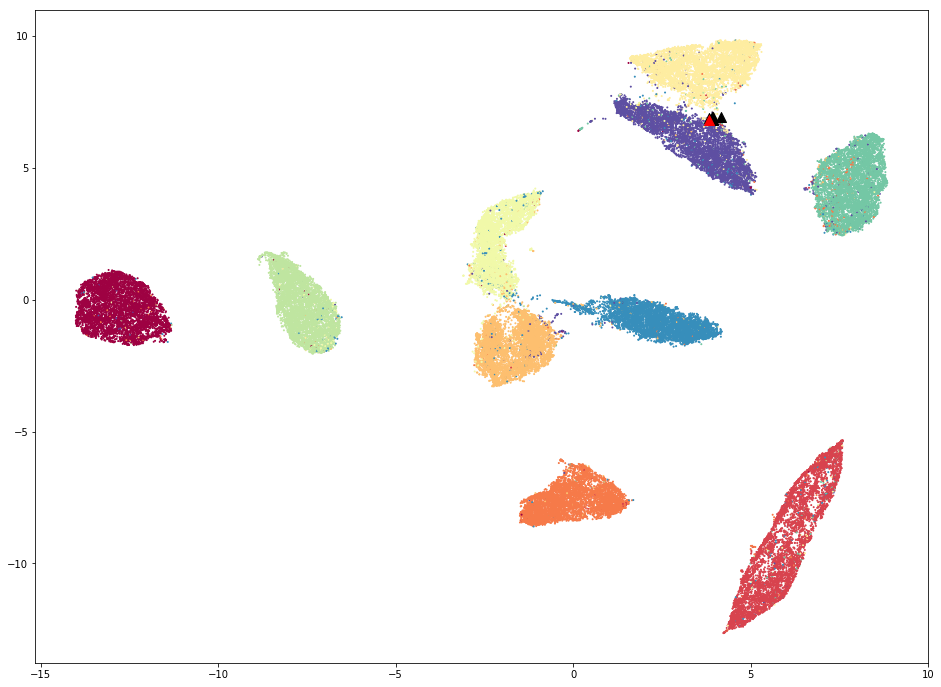

In [5]:
import skfuzzy as skf

# apply fuzzy clustering
centers, memberships, u0, d, jm, p, fpc = skf.cmeans(data.T, 10, 2.0, 1e-8, 1000, seed=0)

# plot the loss
plt.figure(figsize=(16, 4))
plt.plot(np.arange(p)+1, jm)

# plot data with centers
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:,0], embedded[:,1], s=1, c=train_labels, cmap='Spectral')

embedded_centers = reducer.transform(centers)
plt.scatter(embedded_centers[:,0], embedded_centers[:,1], s=100, c="k", marker="^")

centroid = reducer.transform(np.mean(data, axis=0, keepdims=True)).squeeze()
plt.scatter(centroid[0], centroid[1], s=100, c="r", marker="^")

As the plots above show, the fuzzy clustering was unsuccessful when initialized randomly. After only 2 iterations the loss function reaches a local minimum and gets stuck. All of the clusters (represented by the black triangles) are all gathered near the center of mass of the MNIST training data (represented by the red triangle).

More information about why the algorithm fails can be found in this paper: https://www.researchgate.net/publication/225005392_Fuzzy_C-Means_in_High_Dimensional_Spaces

### Initializing the Membership Matrix
Since a random initialization fails, I will investigate using the training labels to create an initial membership matrix that will allow the algorithm to converge to a more appropriate solution.

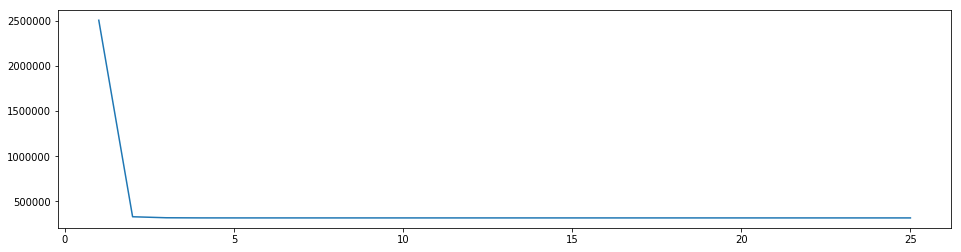

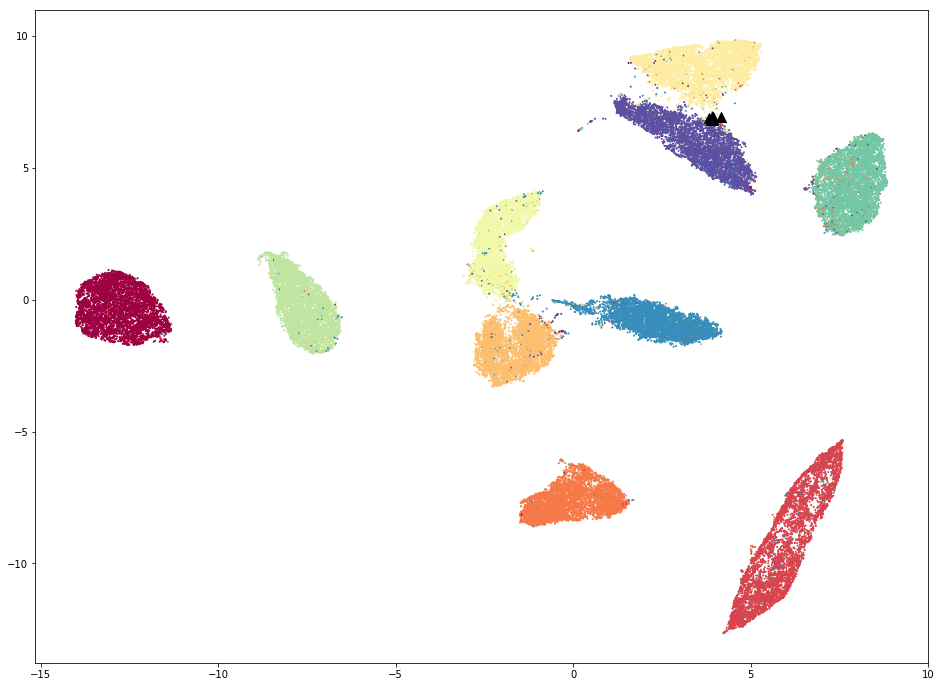

In [6]:
init_memberships = np.zeros((10, 60000))
init_memberships[train_labels,np.arange(60000)] = 1

centers, memberships, u0, d, jm, p, fpc = skf.cmeans(
    data.T, 10, 2.0, 1e-8, 1000, init=init_memberships, seed=0)

# plot the loss
plt.figure(figsize=(16, 4))
plt.plot(np.arange(p)+1, jm)

# plot data with centers
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:,0], embedded[:,1], s=1, c=train_labels, cmap='Spectral')

embedded_centers = reducer.transform(centers)
plt.scatter(embedded_centers[:,0], embedded_centers[:,1], s=100, c="k", marker="^")

Even with the smarter initialization, the fuzzy clustering algorithm still moves the cluster centers to the center of gravity of the entire dataset.

Another, solution to investigate set the exponents variable according to the following equation.

\begin{align}
\omega & = \frac{n + 2}{n}
\end{align}

This leads to better results in high dimensions However, this is effectively makes each cluster less fuzzy and more crisp.

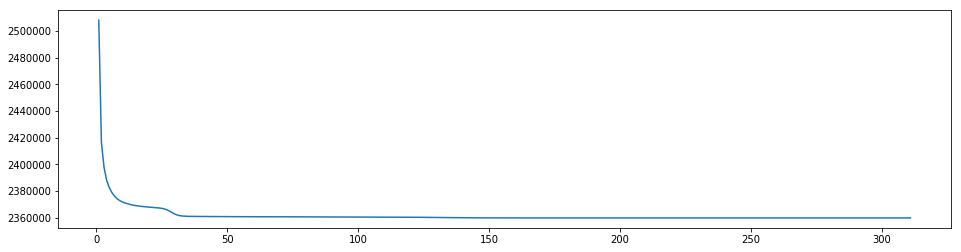

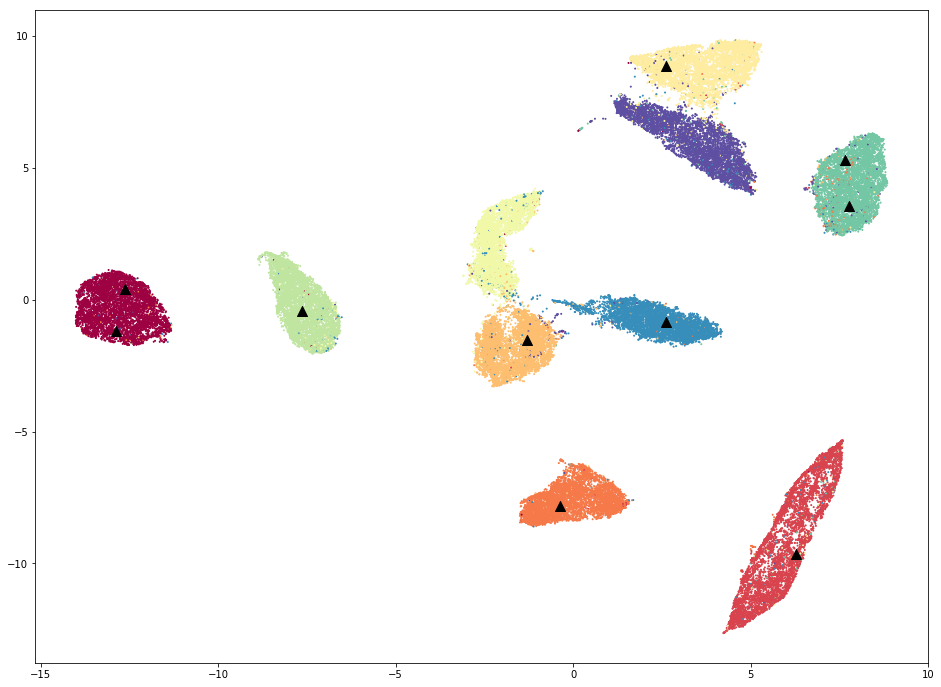

In [7]:
omega = 1 + 2 / 784

centers, memberships, u0, d, jm, p, fpc = skf.cmeans(
    data.T, 10, omega, 1e-8, 1000, init=init_memberships, seed=0)

# plot the loss
plt.figure(figsize=(16, 4))
plt.plot(np.arange(p)+1, jm)

# plot data with centers
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:,0], embedded[:,1], s=1, c=train_labels, cmap='Spectral')

embedded_centers = reducer.transform(centers)
plt.scatter(embedded_centers[:,0], embedded_centers[:,1], s=100, c="k", marker="^")

While the results above are still not ideal (some of the centers appear to share the same clusters), they are much better than the results achieved initially. We can also compare the membership values returned by the cmeans function and the true memberships to get an idea of how well the clustering performed.

In [8]:
pred_labels = np.argmax(memberships, axis=0)
accuracy = np.mean(train_labels == pred_labels)

print("Clustering Accuracy: {:.2%}".format(accuracy))

Clustering Accuracy: 55.55%


Using the data points, centers and membership values we can fit the value of sigma for each membership function. The method used replicates MATLABs genfis function and is based on source code found at the following links.

http://en.verysource.com/code/5248161_1/invgaussmf4sigma.m.html
   
http://read.pudn.com/downloads215/sourcecode/math/1013060/Fuzzy_part1/genfis3.m__.htm

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff201192f98>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff201195668>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff201192b70>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff201195cf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff201195dd8>],
 'means': []}

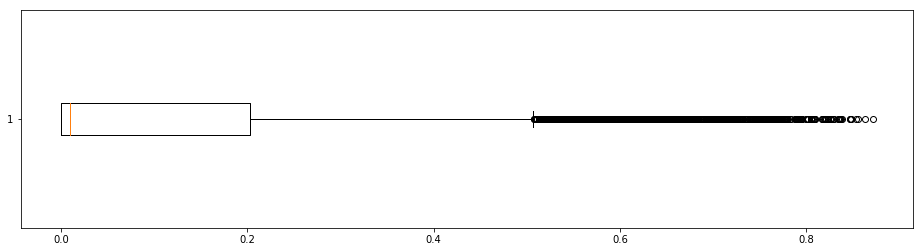

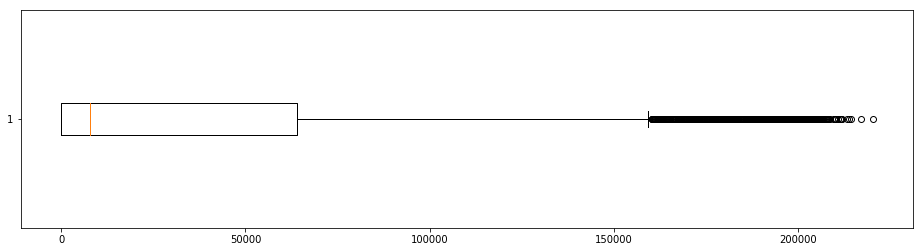

In [9]:
data = train_images.reshape(60000, 28 * 28).T

def compute_sigma(data, memberships, centers):
    # remove any points with a membership of one
    mask = np.any(memberships >= 1.0, axis=0)
    data = data[:,~mask]
    memberships = memberships[:,~mask]
    
    data = np.expand_dims(data, axis=0)
    memberships = np.expand_dims(memberships, axis=1)
    centers = np.expand_dims(centers, axis=2)
    
    return np.mean(np.sqrt(-np.square(data - centers) / (2 * np.log(memberships))), axis=2)

# parameters for the membership functions
mu = centers
sigma = compute_sigma(data, memberships, centers)

plt.figure(figsize=(16, 4))
plt.boxplot(mu.reshape(-1), vert=False)

plt.figure(figsize=(16, 4))
plt.boxplot(sigma.reshape(-1), vert=False)

While the values for mu are within a reasonable range, the values for sigma contain lots of zeros (which means membership values will be zero) and lots of extremely large numbers (which will give membership values of ~1 always). The parameters for sigma cannot be used in the model and will lead to computational problems due to the limited precision of floating point numbers.

<Figure size 432x288 with 0 Axes>

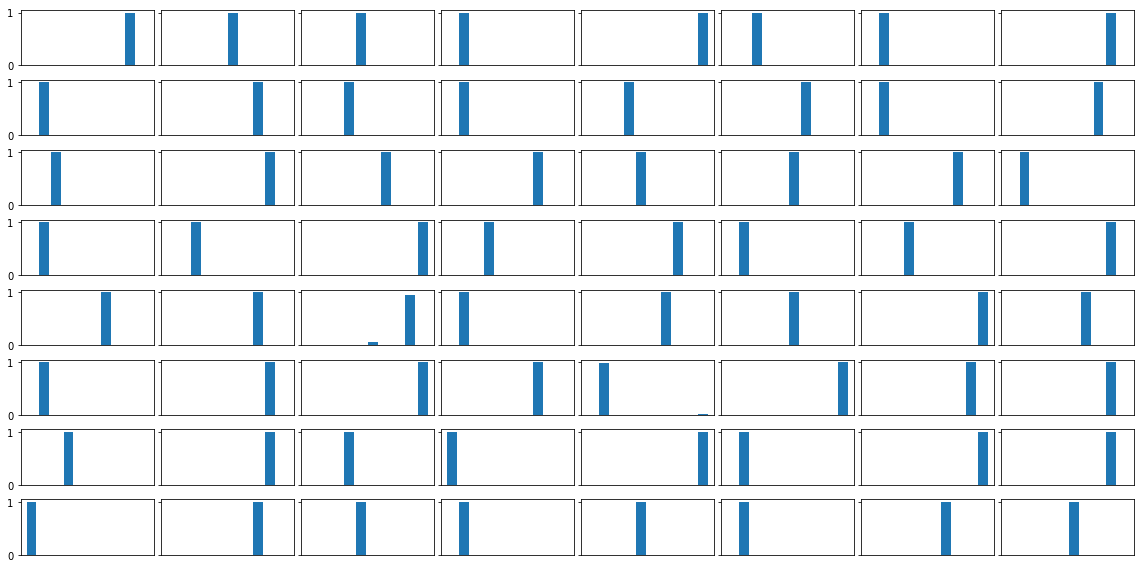

In [10]:
plt.figure()
fig, ax_array = plt.subplots(8, 8, figsize=(16, 8), sharey=True)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.bar(np.arange(10), memberships[:,i])

plt.setp(axes, xticks=[], yticks=[0, 1], frame_on=True)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

The plots above are bar graphs of the membership values for the 64 points in the training data. Because of the small exponent used the membership values essentially mimic crisp clustering. This is the reason for such extreme sigma values.

## Creating the Model
The model will be constructed and analyzed in NumPy to allow for easier inspection of the activations and gradients. Below the model's parameters are defined.

In [11]:
# mu and sigma are also parameters
W = np.random.normal(0, 0.1, size=(10, 10))
b = np.full((1, 10), 0.1)

The first layer applies the membership functions to the inputs.

In [12]:
# use first 100 samples to speed up computation
x = train_images.reshape(-1, 784)[0:100,:]

def first_layer(x):
    # reshape and tile the inputs
    x_reshaped = np.expand_dims(x, 1)
    x_tiled = np.tile(x_reshaped, (1, 10, 1))

    return np.exp(-0.5 * np.square((x_tiled - mu) / sigma))

membership_val = first_layer(x)

print(np.sum(np.isnan(membership_val)))
print(np.size(membership_val))

67000
784000


/home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


The values found for sigma lead to NaN values in the first layer activations. Random normal numbers will be used as placeholders until better initial values can be generated.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff2081aa390>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff2081a3588>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff2081aa908>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff202038860>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff20204a2e8>],
 'means': []}

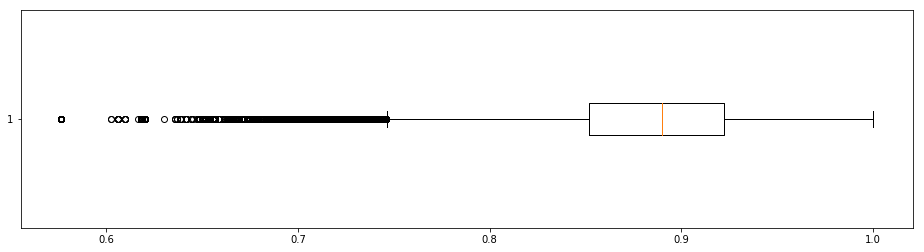

In [13]:
mu = np.random.normal(0.5, 0.1, size=(10, 784))
sigma = np.random.normal(1.0, 0.1, size=(10, 784))

membership_val = first_layer(x)

plt.figure(figsize=(16, 4))
plt.boxplot(membership_val.reshape(-1), vert=False)

The random parameters used above give reasonable values for the activations in the first layer. The second layer activations represent the firing strength of each rule. Similar ANFIS we will be using multiplication as the t-norm operator.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff211cd65f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff211cd8d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff211cd6a90>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff2095b3400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff2095b3c18>],
 'means': []}

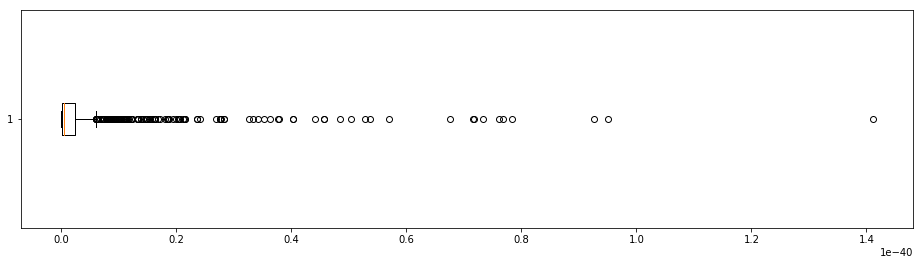

In [14]:
def second_layer(x):
    return np.prod(x, 2)

firing_strength = second_layer(membership_val)

plt.figure(figsize=(16, 4))
plt.boxplot(firing_strength.reshape(-1), vert=False)

This layer causes problems for numerical stability. The multiplication of 784 numbers less than 1 causes extremely small activations in the second layer. This will have to be rectified by some form of normalization.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff211d8fa90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff201e97278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff211d8fd30>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff201e975c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff254a46a58>],
 'means': []}

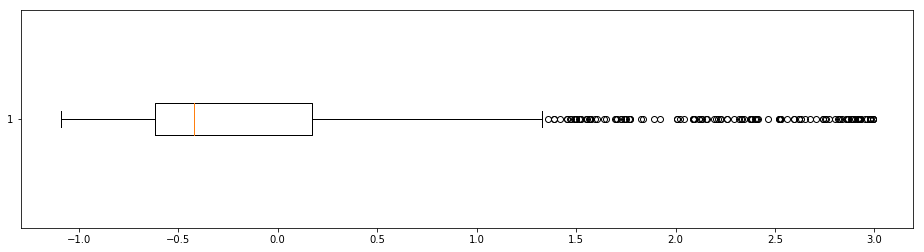

In [15]:
def third_layer(x):
    return (x - np.mean(x, 1, keepdims=True)) / np.std(x, 1, keepdims=True)

normalized = third_layer(firing_strength)

plt.figure(figsize=(16, 4))
plt.boxplot(normalized.reshape(-1), vert=False)

Normalizing the activations to a standard normal distribution gives much more reasonable values while still preserving their magnitudes relative to each other. The classifiers output is a linear combination of normalized firing strength of each rule, with a sigmoid activation applied to bound the result between 0 and 1. Loss will be calculated using binary cross entropy.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff211da2c88>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff208003400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff211da2048>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff208003828>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff211da33c8>],
 'means': []}

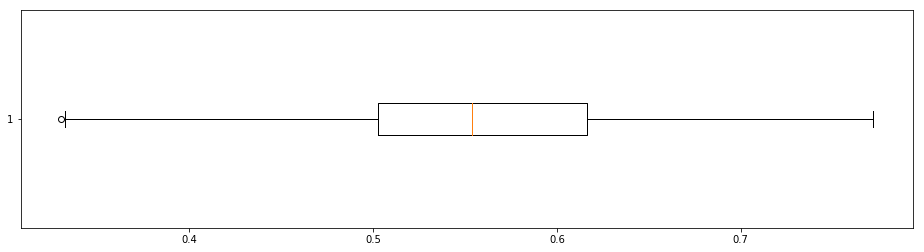

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def final_layer(x):
    logits = np.matmul(x, W) + b
    return sigmoid(logits)

def loss(target, output):
    y = target
    y_ = output
    
    return -(y * np.log(y_) + (1 - y) * np.log(1 - y_))

output = final_layer(normalized)

plt.figure(figsize=(16, 4))
plt.boxplot(output.reshape(-1), vert=False)

Next, the gradients will be computed and inspected for phenomema such as vanishing gradients.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff200980f60>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff200988630>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff200980b38>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff200988cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff200988da0>],
 'means': []}

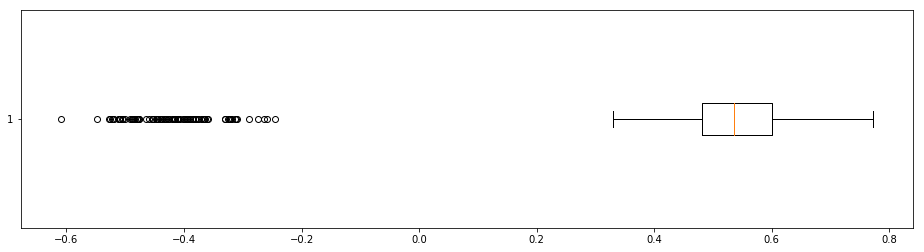

In [17]:
def grad_logits_fn(target, output):
    return output - target

# one-hot training data
train_target = np.zeros((60000, 10))
train_target[np.arange(60000),train_labels] = 1

grad_logits = grad_logits_fn(train_target[0:100,:], output)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_logits.reshape(-1), vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff200902cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff20090d3c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff2009028d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff20090da58>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff20090dda0>],
 'means': []}

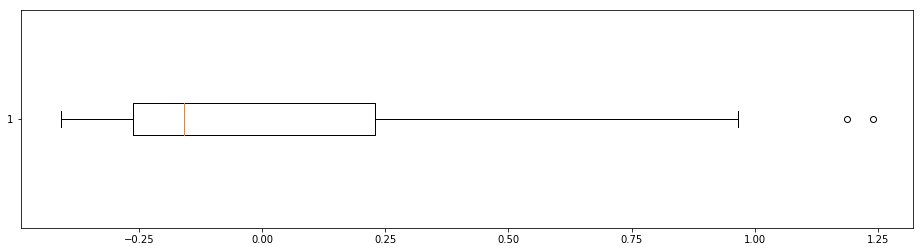

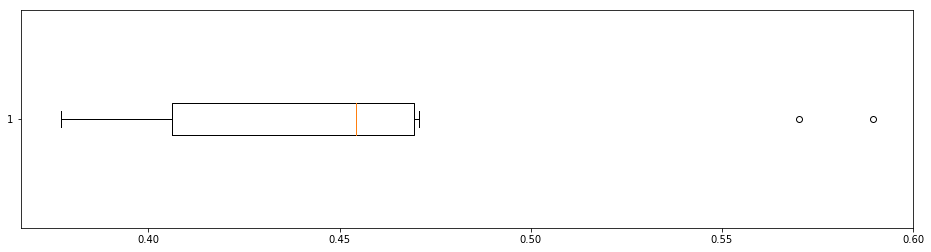

In [18]:
# gradients for affine transformation
def grad_W_fn(grad_logits, normalized):
    return np.matmul(normalized.T, grad_logits) / normalized.shape[0]

def grad_b_fn(grad_logits):
    return np.mean(grad_logits, axis=0, keepdims=True)

grad_W = grad_W_fn(grad_logits, normalized)
grad_b = grad_b_fn(grad_logits)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_W.reshape(-1), vert=False)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_b.reshape(-1), vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff200916518>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff200916e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff2009161d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff2008bc278>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff2008bc748>],
 'means': []}

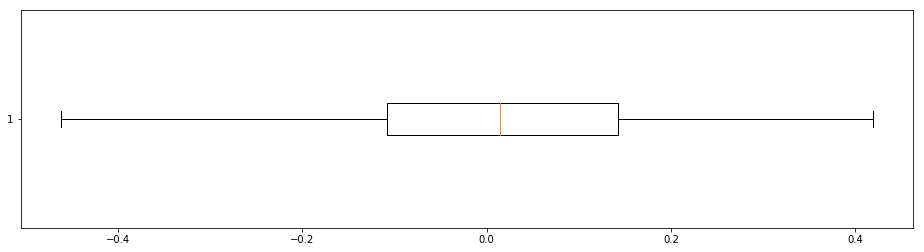

In [19]:
def grad_normalized_fn(grad_logits):
    return np.matmul(grad_logits, W.T)

grad_normalized = grad_normalized_fn(grad_logits)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_normalized.reshape(-1), vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff2008e5e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff2008ee7b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff2008e5cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff2008eee48>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff2008eef28>],
 'means': []}

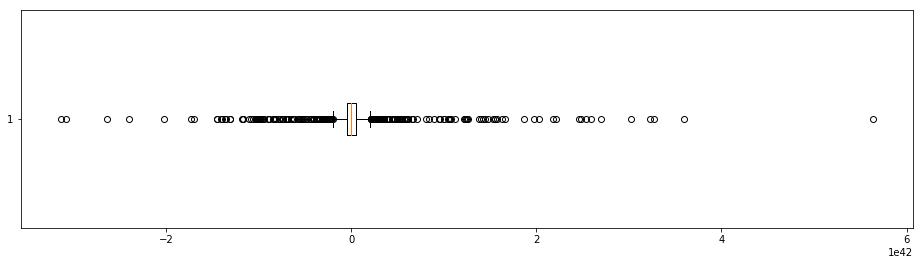

In [20]:
def grad_fstrength_fn(grad_normalized, normalized, firing_strength):
    s = np.std(firing_strength, 1, keepdims=True)
    N = normalized.shape[0]
    
    delta = (1 - 1 / N) / s - np.square(normalized) / (s * (N - 1))
    return delta * grad_normalized

grad_fstrength = grad_fstrength_fn(grad_normalized, normalized, firing_strength)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_fstrength.reshape(-1), vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff2008b4b00>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff2008b4f28>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff2008b46d8>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff20083f860>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff20083fba8>],
 'means': []}

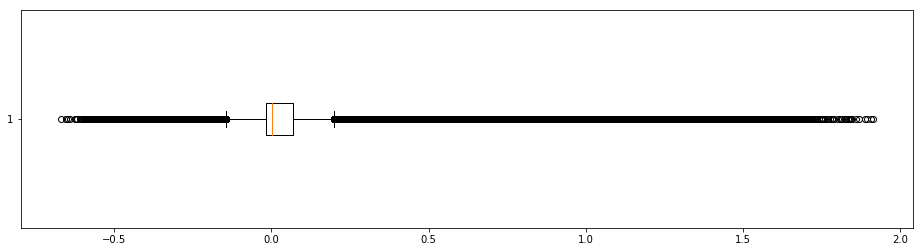

In [21]:
def grad_membership_fn(grad_fstrength, firing_strength, membership_val): 
    return np.expand_dims(grad_fstrength * firing_strength, 2) / membership_val

grad_membership = grad_membership_fn(grad_fstrength, firing_strength, membership_val)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_membership.reshape(-1), vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff2007c44e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff2007c4b70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff2007c40b8>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff2007c4f98>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff2007cd588>],
 'means': []}

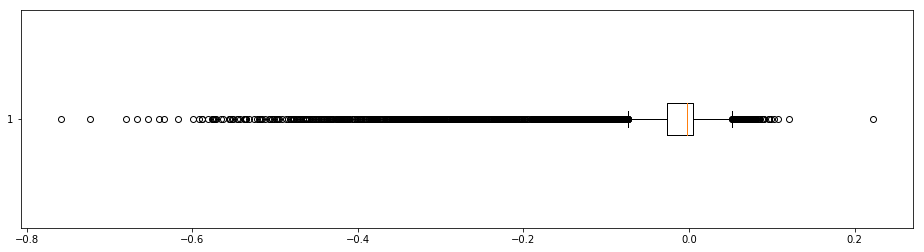

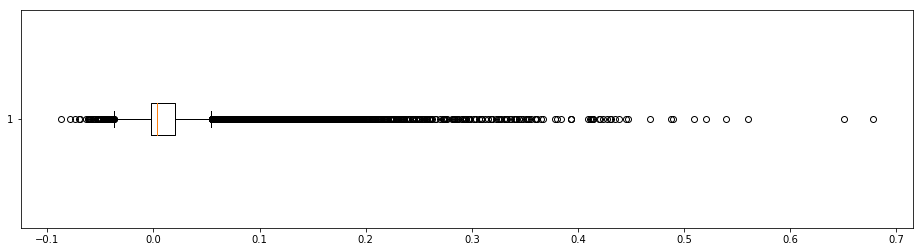

In [22]:
x_tiled = np.tile(np.expand_dims(x, 1), (1, 10, 1))

def grad_mu_fn(grad_membership, mu, sigma, x_tiled, membership_val):
    delta = (x_tiled - mu) / np.square(sigma) * membership_val
    return np.mean(delta * grad_membership, axis=0)

def grad_sigma_fn(grad_membership, mu, sigma, x_tiled, membership_val):
    delta = np.square(x_tiled - mu) / (sigma * sigma * sigma) * membership_val
    return np.mean(delta * grad_membership, axis=0)

grad_mu = grad_mu_fn(grad_membership, mu, sigma, x_tiled, membership_val)
grad_sigma = grad_sigma_fn(grad_membership, mu, sigma, x_tiled, membership_val)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_mu.reshape(-1), vert=False)

plt.figure(figsize=(16, 4))
plt.boxplot(grad_sigma.reshape(-1), vert=False)

All of the gradients appear to have a reasonable magnitude, so vanishing gradients should not be a problem when training this network.

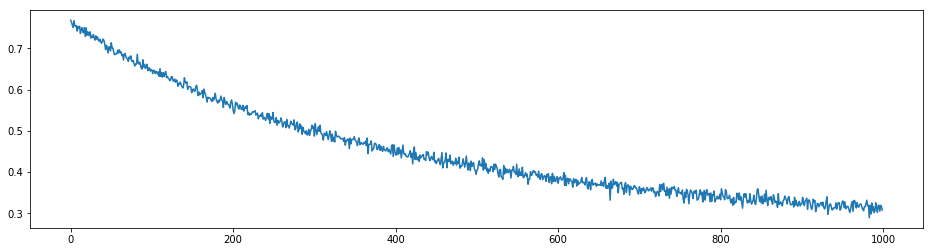

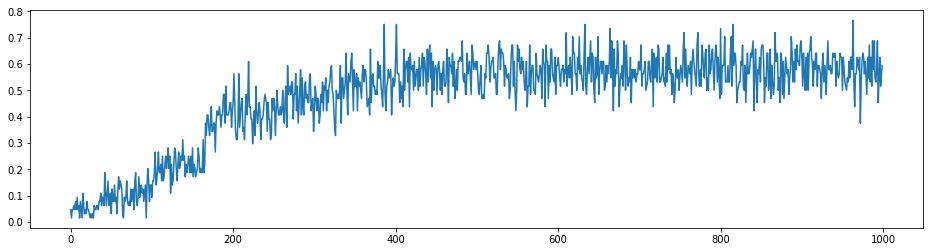

In [23]:
train_x = train_images.reshape(-1, 784)
train_y = train_target

iterations = 1000
batch_size = 64
learning_rate = 0.005

def training_batch(batch_size):
    batch_idx = np.random.randint(0, 60000, size=(batch_size))
    return train_x[batch_idx, :], train_y[batch_idx, :]

def update(param, grad):
    return param - learning_rate * grad

train_loss = []
train_accuracy = []

mu = centers
sigma = np.random.normal(1.0, 0.1, size=(10, 784))

W = np.random.normal(0, 0.1, size=(10, 10))
b = np.full((1, 10), 0.1)

for i in range(iterations):
    batch_x, batch_y = training_batch(batch_size)
    
    # forward pass
    membership_val = first_layer(batch_x)
    firing_strength = second_layer(membership_val)
    normalized = third_layer(firing_strength)
    y = final_layer(normalized)
    
    # calculate loss
    loss_val = np.mean(loss(batch_y, y))
    train_loss.append(loss_val)
    
    accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(batch_y, axis=1))
    train_accuracy.append(accuracy)
    
    # backward pass
    grad_logits = grad_logits_fn(batch_y, y)
    grad_W = grad_W_fn(grad_logits, normalized)
    grad_b = grad_b_fn(grad_logits)
    
    grad_normalized = grad_normalized_fn(grad_logits)
    grad_fstrength = grad_fstrength_fn(grad_normalized, normalized, firing_strength)
    grad_membership = grad_membership_fn(grad_fstrength, firing_strength, membership_val)
    
    x_tiled = np.tile(np.expand_dims(batch_x, 1), (1, 10, 1))
    grad_mu = grad_mu_fn(grad_membership, mu, sigma, x_tiled, membership_val)
    grad_sigma = grad_sigma_fn(grad_membership, mu, sigma, x_tiled, membership_val)
    
    # gradient updates
    W = update(W, grad_W)
    b = update(b, grad_b)
    mu = update(mu, grad_mu)
    sigma = update(sigma, grad_sigma)

plt.figure(figsize=(16, 4))
plt.plot(np.arange(iterations), train_loss)

plt.figure(figsize=(16, 4))
plt.plot(np.arange(iterations), train_accuracy)

In [24]:
test_x = test_images.reshape(-1, 784)
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

# forward pass
membership_val = first_layer(test_x)
firing_strength = second_layer(membership_val)
normalized = third_layer(firing_strength)
y = final_layer(normalized)
    
# calculate loss
loss_val = np.mean(loss(test_y, y))
print("testing loss: {:.3f}".format(loss_val))
    
accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(test_y, axis=1))
print("testing accuracy: {:.2%}".format(accuracy))

testing loss: 0.311
testing accuracy: 58.51%
